In [18]:
# Core imports
import os
import subprocess
import numpy as np
import pandas as pd
import h5py
import random
from urllib.request import urlretrieve

# TensorFlow/Keras imports for model loading
import tensorflow as tf
from keras.models import model_from_json

# SEAM imports
import seam
from seam import Compiler, Attributer, Clusterer, MetaExplainer, Identifier

In [19]:
import os
import subprocess
import numpy as np
import pandas as pd
import h5py

# Create data directory if it doesn't exist
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download data if not present
data_file = os.path.join(data_dir, 'deepstarr_data.h5')
if not os.path.exists(data_file):
    print("Downloading deepstarr_data.h5...")
    url = 'https://www.dropbox.com/scl/fi/cya4ntqk2o8yftxql52lu/deepstarr_data.h5?rlkey=5ly363vqjb3vaw2euw2dhsjo3&st=6eod6fg8&dl=1'
    subprocess.run(['wget', '-O', data_file, url], check=True)
else:
    print(f"Using existing {data_file}")

# Load data
with h5py.File(data_file, 'r') as dataset:
    X_test = np.array(dataset['x_test']).astype(np.float32)

# Create a summary dataframe
df = pd.DataFrame({
    'shape': [X_test.shape],
    'dtype': [X_test.dtype],
    'min': [X_test.min()],
    'max': [X_test.max()],
    'num_sequences': [X_test.shape[0]]
})

print(f"\nData loaded successfully!")
print(f"X_test shape: {X_test.shape}")
print(f"\nSummary:")
print(df)
df.keys()

Using existing data/deepstarr_data.h5

Data loaded successfully!
X_test shape: (41186, 249, 4)

Summary:
             shape    dtype  min  max  num_sequences
0  (41186, 249, 4)  float32  0.0  1.0          41186


Index(['shape', 'dtype', 'min', 'max', 'num_sequences'], dtype='object')

In [20]:
# Download and load the DeepSTARR model
model_dir = '../data_and_models/models/'

# Download model files if not present
model_json_file = os.path.join(model_dir, 'deepstarr.model.json')
model_weights_file = os.path.join(model_dir, 'deepstarr.model.h5')

if not os.path.exists(model_json_file):
    print("Downloading deepstarr.model.json...")
    url = 'https://www.dropbox.com/scl/fi/y1mwsqpv2e514md9t68jz/deepstarr.model.json?rlkey=cdwhstqf96fibshes2aov6t1e&st=9a0c5skz&dl=1'
    urlretrieve(url, model_json_file)
else:
    print(f"Using existing {model_json_file}")

if not os.path.exists(model_weights_file):
    print("Downloading deepstarr.model.h5...")
    url = 'https://www.dropbox.com/scl/fi/6nl6e2hofyw70lh99h3uk/deepstarr.model.h5?rlkey=hqfnivn199xa54bjh8dn2jpaf&st=l4jig4ky&dl=1'
    urlretrieve(url, model_weights_file)
else:
    print(f"Using existing {model_weights_file}")



# Load the model architecture from JSON
with open(model_json_file, 'r') as f:
    model_json = f.read()

model = model_from_json(model_json, custom_objects={'Functional': tf.keras.Model})

# Set random seeds for reproducibility
np.random.seed(114)
random.seed(0)

# Load the model weights
model.load_weights(model_weights_file)
num_tasks = 2  # Dev [0] and Hk [1]

alphabet = ['A','C','G','T']

x_ref = X_test[0]
x_ref = np.expand_dims(x_ref,0)


# Define mutagenesis window for sequence
seq_length = x_ref.shape[1]
mut_window = [0, seq_length]  # [start_position, stop_position]
print("\nModel loaded successfully!")

# Forward pass to get output for the specific head
output = model(x_ref)
predd,predh = model.predict(x_ref)[0], model.predict(x_ref)[1]
print(f"\nWild-type predictions: {predd[0][0], predh[0][0]}")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

Using existing ../data_and_models/models/deepstarr.model.json
Using existing ../data_and_models/models/deepstarr.model.h5


2026-01-23 10:05:27.369142: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_73_3/gamma/Assign' id:5229 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_73_3/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_73_3/gamma, batch_normalization_73_3/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Model loaded successfully!

Wild-type predictions: (2.8394015, 0.8605407)
Model input shape: (None, 249, 4)
Model output shape: [(None, 1), (None, 1)]


/grid/wsbs/home_norepl/pmantill/SEAM_revisions/SEAM_revisions/.venv/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2026-01-23 10:05:27.628205: W tensorflow/c/c_api.cc:291] Operation '{name:'Dense_Dev_3/BiasAdd' id:5816 op device:{requested: '', assigned: ''} def:{{{node Dense_Dev_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](Dense_Dev_3/MatMul, Dense_Dev_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [21]:
## paper seqs

paper_loci_idx = [22612, 21069, 13748]

paper_loci = []
for i in paper_loci_idx:
    seq = X_test[i]
    paper_loci.append(seq)

paper_loci[0].shape

(249, 4)

Selecting 40 random DEV sequences with activity > 2...
Found 1/40: idx=5486, activity=2.463
Found 2/40: idx=21102, activity=3.602
Found 3/40: idx=837, activity=2.941
Found 4/40: idx=562, activity=3.402
Found 5/40: idx=26580, activity=2.471
Found 6/40: idx=13667, activity=3.082
Found 7/40: idx=21050, activity=2.440
Found 8/40: idx=22498, activity=2.298
Found 9/40: idx=7303, activity=2.419
Found 10/40: idx=1006, activity=3.643
Found 11/40: idx=19500, activity=2.776
Found 12/40: idx=21292, activity=3.199
Found 13/40: idx=22538, activity=2.443
Found 14/40: idx=404, activity=2.554
Found 15/40: idx=21028, activity=3.856
Found 16/40: idx=16564, activity=2.680
Found 17/40: idx=9373, activity=2.464
Found 18/40: idx=21833, activity=2.181
Found 19/40: idx=23120, activity=2.199
Found 20/40: idx=508, activity=3.113
Found 21/40: idx=29829, activity=3.562
Found 22/40: idx=22507, activity=2.705
Found 23/40: idx=22078, activity=2.813
Found 24/40: idx=8837, activity=2.223
Found 25/40: idx=1630, activity

2026-01-23 10:05:29.505789: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_73_4/gamma/Assign' id:6649 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_73_4/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_73_4/gamma, batch_normalization_73_4/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Parameters for deepshap:

Required:
x: array, Input sequences to compute attributions for

Optional:
background: array, Background sequences for DeepSHAP (optional). Shape: (N, L, A). If not provided, will generate shuffled backgrounds using num_shuffles.

Common Optional:
x_ref: array, Reference sequence for comparison (optional). Shape: (1, L, A). Used for padding in windowed analysis when save_window is specified. Not used for DeepSHAP background.
save_window: list, Window [start, end] to compute attributions (optional). When provided with x_ref, allows computing attributions for a subset of positions while maintaining full sequence context. Input x should contain only the windowed region with shape (N, end-start, A), and x_ref provides the full-length context with shape (1, L, A). Example: [100, 200] computes attributions for positions 100-200.
Done 0 examples of 40
Attribution time: 0.02 minutes

Generating attribution map visualizations...


Processing logos:   0%|          | 0/40 [00:00<?, ?it/s]findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
Processing logos: 100%|██████████| 40/40 [00:00<00:00, 50.21it/s]


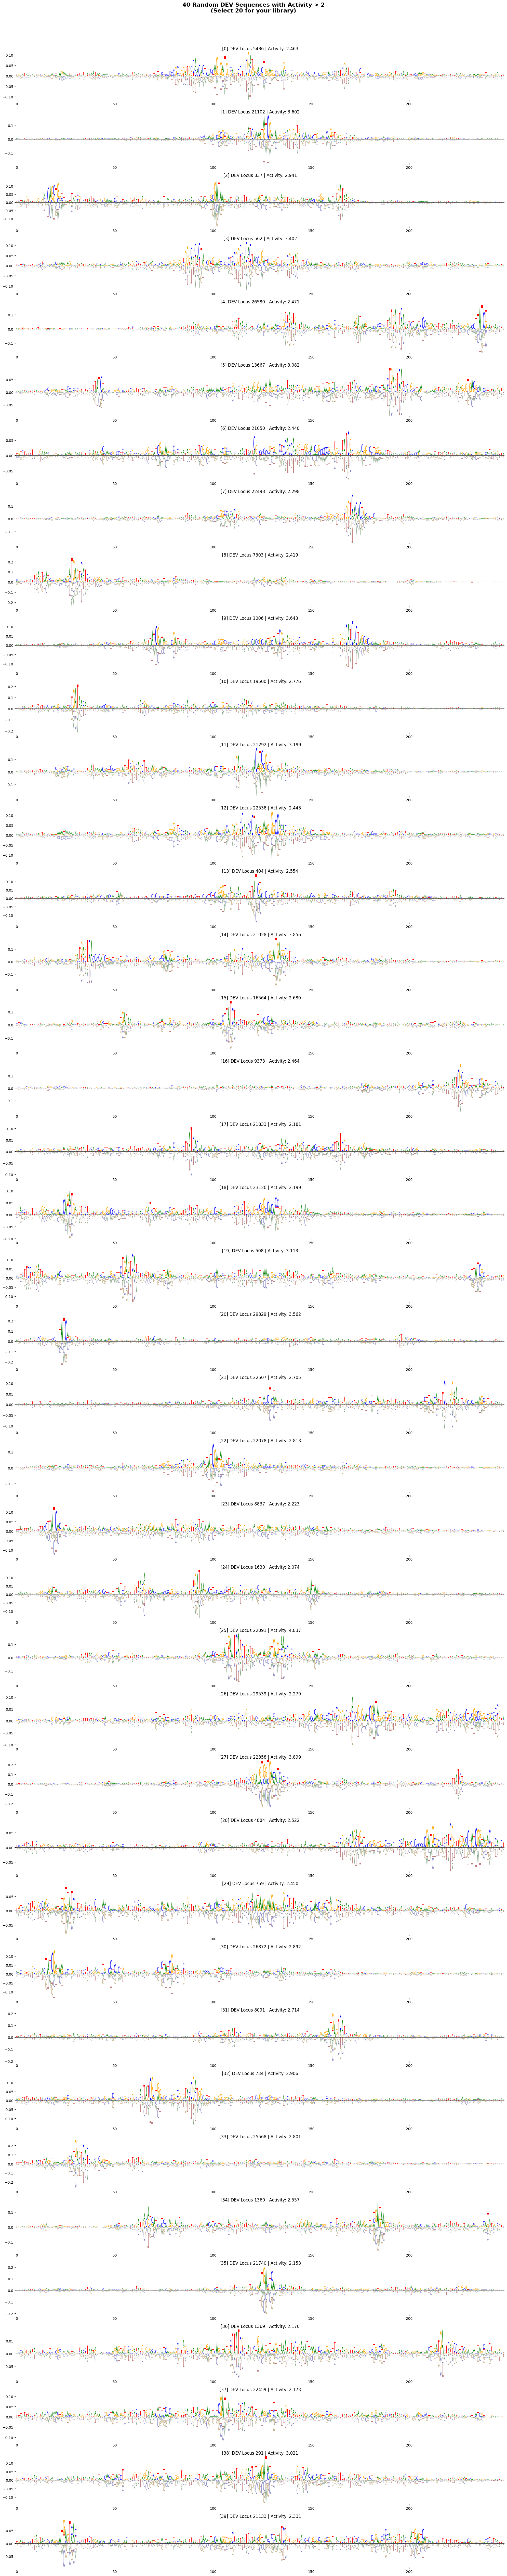


SUMMARY: Test indices and activities for manual selection
[ 0] Test idx:  5486 | Activity: 2.463
[ 1] Test idx: 21102 | Activity: 3.602
[ 2] Test idx:   837 | Activity: 2.941
[ 3] Test idx:   562 | Activity: 3.402
[ 4] Test idx: 26580 | Activity: 2.471
[ 5] Test idx: 13667 | Activity: 3.082
[ 6] Test idx: 21050 | Activity: 2.440
[ 7] Test idx: 22498 | Activity: 2.298
[ 8] Test idx:  7303 | Activity: 2.419
[ 9] Test idx:  1006 | Activity: 3.643
[10] Test idx: 19500 | Activity: 2.776
[11] Test idx: 21292 | Activity: 3.199
[12] Test idx: 22538 | Activity: 2.443
[13] Test idx:   404 | Activity: 2.554
[14] Test idx: 21028 | Activity: 3.856
[15] Test idx: 16564 | Activity: 2.680
[16] Test idx:  9373 | Activity: 2.464
[17] Test idx: 21833 | Activity: 2.181
[18] Test idx: 23120 | Activity: 2.199
[19] Test idx:   508 | Activity: 3.113
[20] Test idx: 29829 | Activity: 3.562
[21] Test idx: 22507 | Activity: 2.705
[22] Test idx: 22078 | Activity: 2.813
[23] Test idx:  8837 | Activity: 2.223
[24] 

In [22]:
# =============================================================================
# SELECT 40 RANDOM DEV SEQUENCES WITH HIGH ACTIVITY (>2) AND VISUALIZE
# =============================================================================

import matplotlib.pyplot as plt
from seam.logomaker_batch.batch_logo import BatchLogo

# -----------------------------------------------------------------------------
# Define seam_deepshap function (from library_visualization.ipynb)
# -----------------------------------------------------------------------------
def seam_deepshap(x_mut, task_index):
    x_ref = x_mut
    import time
    import tensorflow as tf
    from keras.models import model_from_json
    import numpy as np
    import random

    # Configuration
    attribution_method = 'deepshap'
    gpu = 0
    save_path = './attributions'
    os.makedirs(save_path, exist_ok=True)

    # Model paths - adjusted for this notebook's location
    keras_model_json = '../data_and_models/models/deepstarr.model.json'
    keras_model_weights = '../data_and_models/models/deepstarr.model.h5'

    try:
        # Disable eager execution first
        tf.compat.v1.disable_eager_execution()
        tf.compat.v1.disable_v2_behavior()
        print("TensorFlow eager execution disabled for DeepSHAP compatibility")
        
        # Import SHAP to configure handlers
        try:
            import shap
        except ImportError:
            print("ERROR: SHAP package is not installed.")
            print("To install SHAP for DeepSHAP attribution, run:")
            print("pip install kundajelab-shap==1")
            raise ImportError("SHAP package required for DeepSHAP attribution")
        
        # Handle AddV2 operation (element-wise addition) as a linear operation
        shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

        # Load the model after eager execution is disabled
        keras_model = model_from_json(open(keras_model_json).read(), custom_objects={'Functional': tf.keras.Model})
        np.random.seed(113)
        random.seed(0)
        keras_model.load_weights(keras_model_weights)
        shap_model = keras_model
        
        # Rebuild model to ensure proper graph construction
        _ = shap_model(tf.keras.Input(shape=shap_model.input_shape[1:]))
        
    except ImportError:
        raise
    except Exception as e:
        print(f"Warning: Could not setup TensorFlow for DeepSHAP. Error: {e}")
        print("DeepSHAP may not work properly.")
    
    # Create attributer for DeepSHAP
    def deepstarr_compress(x):
        """DeepSTARR compression function for DeepSHAP."""
        if hasattr(x, 'outputs'):
            return tf.reduce_sum(x.outputs[task_index], axis=-1)
        else:
            return x

    attributer = Attributer(
        shap_model,
        method=attribution_method,
        task_index=task_index,
        compress_fun=deepstarr_compress
    )

    attributer.show_params(attribution_method)

    t1 = time.time()
    attributions = attributer.compute(
        x_ref=x_ref,
        x=x_mut,
        save_window=None,
        batch_size=16,
        gpu=gpu,
    )
    t2 = time.time() - t1
    print(f'Attribution time: {t2/60:.2f} minutes')

    return attributions

# -----------------------------------------------------------------------------
# Randomly select 40 DEV sequences with activity > 2
# -----------------------------------------------------------------------------
threshold = 2
task_index = 0  # DEV head
n_seqs = 40

print(f"Selecting {n_seqs} random DEV sequences with activity > {threshold}...")
dev_candidates = []
seen_idx = set()

while len(dev_candidates) < n_seqs:
    idx = int(np.random.uniform(0, len(X_test)))
    if idx in seen_idx:
        continue
    seen_idx.add(idx)
    
    seq = X_test[idx:idx+1]
    pred = model.predict(seq, verbose=0)[task_index][0][0]
    if pred > threshold:
        dev_candidates.append({'idx': idx, 'seq': seq[0], 'activity': pred})
        print(f"Found {len(dev_candidates)}/{n_seqs}: idx={idx}, activity={pred:.3f}")

print(f"\nSelected {len(dev_candidates)} DEV sequences with activity > {threshold}")

# -----------------------------------------------------------------------------
# Compute DeepSHAP attributions for all 40 sequences
# -----------------------------------------------------------------------------
print("\nComputing DeepSHAP attributions...")
all_seqs = np.array([c['seq'] for c in dev_candidates])
attributions = seam_deepshap(all_seqs, task_index=task_index)

# -----------------------------------------------------------------------------
# Visualize all 40 attribution maps using BatchLogo
# -----------------------------------------------------------------------------
print("\nGenerating attribution map visualizations...")

fig, axes = plt.subplots(n_seqs, 1, figsize=(20, 2.5 * n_seqs))

# Ensure axes is iterable even if only one row
if n_seqs == 1:
    axes = [axes]

# Create BatchLogo for all sequences
batch_logo = BatchLogo(
    attributions,
    alphabet=alphabet,
    font_name='Arial Rounded MT Bold',
    fade_below=0.5,
    shade_below=0.5,
    width=0.9,
    center_values=True,
    batch_size=n_seqs
)

batch_logo.process_all()

# Plot each sequence
for row_idx in range(n_seqs):
    ax = axes[row_idx]
    
    # Draw logo on the subplot
    batch_logo.draw_single(row_idx, ax=ax, border=False)
    
    # Add title with info
    test_idx = dev_candidates[row_idx]['idx']
    activity = dev_candidates[row_idx]['activity']
    
    title = f'[{row_idx}] DEV Locus {test_idx} | Activity: {activity:.3f}'
    ax.set_title(title, fontsize=12, pad=5)

plt.suptitle('40 Random DEV Sequences with Activity > 2\n(Select 20 for your library)', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Print summary for easy selection
print("\n" + "="*60)
print("SUMMARY: Test indices and activities for manual selection")
print("="*60)
for i, c in enumerate(dev_candidates):
    print(f"[{i:2d}] Test idx: {c['idx']:5d} | Activity: {c['activity']:.3f}")

In [41]:
selected_seqs = [22612, 21069, 13748, 21916, 3881, 2974, 22386, 25078, 20726, 28234, 8389, 705, 8092, 1693, 30858, 35428, 28088, 21045, 21289, 266, 562, 22498, 1006]
len(set(selected_seqs))

23

In [33]:
# =============================================================================
# SAVE DEV 23 LIBRARY (3 paper + 20 random high activity)
# =============================================================================
from seam.utils import oh2seq
import pickle

selected_idx = selected_seqs

print(f"Total sequences: {len(selected_idx)} (3 paper + {len(selected_idx)-3} random)")

# Extract sequences and compute activities
dev_loci = []
dev_pred = []
string_seqs = []

for idx in selected_idx:
    seq = X_test[idx]
    dev_loci.append(seq)
    
    # Get DEV activity (task_index=0)
    pred = model.predict(np.expand_dims(seq, 0), verbose=0)[0][0][0]
    dev_pred.append(pred)
    
    # Convert to string
    string_seqs.append(oh2seq(seq))

# Create DataFrame
dev_20_library = pd.DataFrame({
    "test_idx": selected_idx,
    "sequence": string_seqs,
    "activity": dev_pred,
    "ohe_seq": dev_loci
})

print(f"Dev 20 Library: {len(dev_20_library)} sequences")
print(dev_20_library[['test_idx', 'activity']].to_string())

# Save to pickle
os.makedirs('Dev_20_library/Dev_20', exist_ok=True)
with open('Dev_20_library/Dev_20/dev_20_library.pkl', 'wb') as f:
    pickle.dump({'dev': dev_20_library}, f)

print("\nSaved to Dev_20_library/Dev_20/dev_20_library.pkl")

Total sequences: 23 (3 paper + 20 random)
Dev 20 Library: 23 sequences
    test_idx  activity
0      22612  3.265582
1      21069  4.790910
2      13748  3.756077
3      21916  2.296374
4       3881  2.158696
5       2974  2.735814
6      22386  2.260624
7      25078  3.947875
8      20726  3.767267
9      28234  2.053969
10      8389  2.038210
11       705  2.734945
12      8092  2.211084
13      1693  2.281726
14     30858  3.148597
15     35428  2.004486
16     28088  2.345703
17     21045  2.612440
18     21289  2.739905
19       266  3.829065
20       562  3.402123
21     22498  2.298452
22      1006  3.642516

Saved to Dev_20_library/Dev_20/dev_20_library.pkl
